# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
seed = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

If you do not have a GPU, uncomment and run the next commands.

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [5]:
from google.colab import drive
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.utils import shuffle
from sklearn import metrics

In [6]:
tf.__version__

'2.7.0'

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [10]:
from efficientnet_lite import EfficientNetLiteB0

# 2. Utility Functions

You can use this function to load your training data.

In [11]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [12]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [13]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [14]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [15]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [16]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [17]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [18]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [19]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [20]:
y_train.shape

TensorShape([80])

In [21]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

In [22]:
x_train = x_train.numpy().astype(np.int32)
y_train = y_train.numpy()

### Train val split

In [23]:
# put every first and second image per class into val set
# this creates a stratified val set
# loaded images must not be shuffled
# val images must not be augmented to resemble private test set as closely as possible
i1 = 0
i2 = 1
step = 10
val_indices = [i1,
               i2,
               i1 + step,
               i2 + step,
               i1 + 2 * step,
               i2 + 2 * step,
               i1 + 3 * step,
               i2 + 3 * step,
               i1 + 4 * step,
               i2 + 4 * step,
               i1 + 5 * step,
               i2 + 5 * step,
               i1 + 6 * step,
               i2 + 6 * step,
               i1 + 7 * step,
               i2 + 7 * step]
val_indices

[0, 1, 10, 11, 20, 21, 30, 31, 40, 41, 50, 51, 60, 61, 70, 71]

In [24]:
#x_val = x_train[val_indices, :]
#y_val = y_train[val_indices]
#print(x_val.shape, y_val.shape)

In [25]:
#for i in np.arange(num_classes):
#    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

In [26]:
#x_train = np.delete(x_train, val_indices, axis=0)
#y_train = np.delete(y_train, val_indices, axis=0)
#print(x_train.shape, y_train.shape)

In [27]:
#for i in np.arange(num_classes):
#    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

### Augment train images

#### Try out different augmentations

In [28]:
image_to_visualize = 18

Class: Cloud


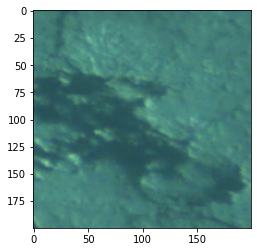

In [29]:
visualize_image(x_train, y_train, image_to_visualize)

tf.Tensor(
[[[ 94.69458193 154.69457835 136.69457942]
  [ 93.69458199 149.69457865 134.69457954]
  [ 93.69458199 148.69457871 134.69457954]
  ...
  [ 88.69458228 143.69457901 136.69457942]
  [ 87.69458234 145.69457889 137.69457936]
  [ 87.69458234 142.69457906 138.6945793 ]]

 [[100.69458157 154.69457835 137.69457936]
  [ 97.69458175 151.69457853 136.69457942]
  [ 93.69458199 150.69457859 134.69457954]
  ...
  [ 88.69458228 144.69457895 135.69457948]
  [ 87.69458234 144.69457895 136.69457942]
  [ 86.6945824  143.69457901 137.69457936]]

 [[106.69458121 159.69457805 140.69457918]
  [100.69458157 150.69457859 137.69457936]
  [ 90.69458216 149.69457865 137.69457936]
  ...
  [ 85.69458246 143.69457901 133.6945796 ]
  [ 85.69458246 143.69457901 135.69457948]
  [ 86.6945824  142.69457906 136.69457942]]

 ...

 [[ 66.694576   115.69458067 118.6945805 ]
  [ 74.69457552 121.69458032 123.6945802 ]
  [ 82.69457504 136.69457942 130.69457978]
  ...
  [ 86.6945824  147.69457877 138.6945793 ]
  [ 86.

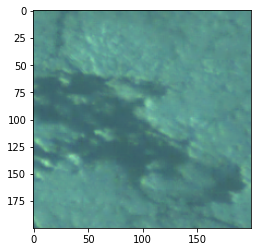

In [30]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
brightness_example = tf.image.stateless_random_brightness(x_train[image_to_visualize]/255, 0.2, augmentation_seed)*255
print(brightness_example)
plt.imshow(brightness_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 74 134 116]
  [ 73 129 114]
  [ 73 128 114]
  ...
  [ 68 123 116]
  [ 67 125 117]
  [ 67 122 118]]

 [[ 80 134 117]
  [ 77 131 116]
  [ 73 130 114]
  ...
  [ 68 124 115]
  [ 67 124 116]
  [ 66 123 117]]

 [[ 86 139 120]
  [ 80 130 117]
  [ 70 129 117]
  ...
  [ 65 123 113]
  [ 65 123 115]
  [ 66 122 116]]

 ...

 [[ 46  95  98]
  [ 54 101 103]
  [ 62 116 110]
  ...
  [ 66 127 118]
  [ 66 125 117]
  [ 66 127 117]]

 [[ 40  87  93]
  [ 48  92  99]
  [ 57 105 106]
  ...
  [ 66 125 117]
  [ 65 121 115]
  [ 63 122 116]]

 [[ 39  82  88]
  [ 44  88  96]
  [ 50  92 102]
  ...
  [ 66 122 116]
  [ 65 121 114]
  [ 63 121 116]]], shape=(200, 200, 3), dtype=int32)


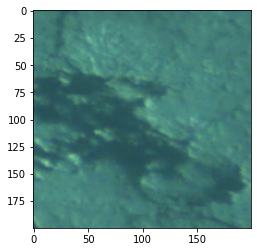

In [31]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_left_right_example = tf.image.stateless_random_flip_left_right(x_train[image_to_visualize], augmentation_seed)
print(flip_left_right_example)
plt.imshow(flip_left_right_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 39  82  88]
  [ 44  88  96]
  [ 50  92 102]
  ...
  [ 66 122 116]
  [ 65 121 114]
  [ 63 121 116]]

 [[ 40  87  93]
  [ 48  92  99]
  [ 57 105 106]
  ...
  [ 66 125 117]
  [ 65 121 115]
  [ 63 122 116]]

 [[ 46  95  98]
  [ 54 101 103]
  [ 62 116 110]
  ...
  [ 66 127 118]
  [ 66 125 117]
  [ 66 127 117]]

 ...

 [[ 86 139 120]
  [ 80 130 117]
  [ 70 129 117]
  ...
  [ 65 123 113]
  [ 65 123 115]
  [ 66 122 116]]

 [[ 80 134 117]
  [ 77 131 116]
  [ 73 130 114]
  ...
  [ 68 124 115]
  [ 67 124 116]
  [ 66 123 117]]

 [[ 74 134 116]
  [ 73 129 114]
  [ 73 128 114]
  ...
  [ 68 123 116]
  [ 67 125 117]
  [ 67 122 118]]], shape=(200, 200, 3), dtype=int32)


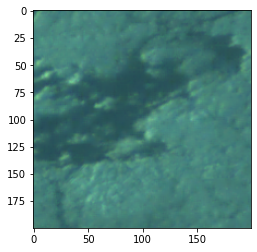

In [32]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_up_down_example = tf.image.stateless_random_flip_up_down(x_train[image_to_visualize], augmentation_seed)
print(flip_up_down_example)
plt.imshow(flip_up_down_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 74 134 116]
  [ 73 129 114]
  [ 73 128 114]
  ...
  [ 68 123 116]
  [ 67 125 117]
  [ 67 122 118]]

 [[ 80 134 117]
  [ 77 131 116]
  [ 73 130 114]
  ...
  [ 68 124 115]
  [ 67 124 116]
  [ 66 123 117]]

 [[ 86 139 120]
  [ 80 130 117]
  [ 70 129 117]
  ...
  [ 65 123 113]
  [ 65 123 115]
  [ 66 122 116]]

 ...

 [[ 46  95  98]
  [ 54 101 103]
  [ 62 116 110]
  ...
  [ 66 127 118]
  [ 66 125 117]
  [ 66 127 117]]

 [[ 40  87  93]
  [ 48  92  99]
  [ 57 105 106]
  ...
  [ 66 125 117]
  [ 65 121 115]
  [ 63 122 116]]

 [[ 39  82  88]
  [ 44  88  96]
  [ 50  92 102]
  ...
  [ 66 122 116]
  [ 65 121 114]
  [ 63 121 116]]], shape=(200, 200, 3), dtype=int32)


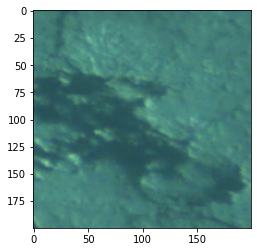

In [33]:
k = random.choice([0, 1, 2, 3])
rot90_example = tf.image.rot90(x_train[image_to_visualize], k=k)
print(rot90_example)
plt.imshow(rot90_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 74 134  95]
  [ 73 129  94]
  [ 73 128  94]
  ...
  [ 68 123  96]
  [ 67 125  96]
  [ 67 122  98]]

 [[ 80 134  98]
  [ 77 131  97]
  [ 73 130  94]
  ...
  [ 68 124  95]
  [ 67 124  96]
  [ 66 123  97]]

 [[ 86 139 101]
  [ 80 130  99]
  [ 70 129  96]
  ...
  [ 65 123  92]
  [ 65 123  94]
  [ 66 122  96]]

 ...

 [[ 46  98  82]
  [ 54 103  87]
  [ 62 116  91]
  ...
  [ 66 127  96]
  [ 66 125  96]
  [ 66 127  95]]

 [[ 40  93  80]
  [ 48  99  88]
  [ 57 106  89]
  ...
  [ 66 125  96]
  [ 65 121  95]
  [ 63 122  95]]

 [[ 39  88  76]
  [ 44  96  85]
  [ 49 102  93]
  ...
  [ 66 122  96]
  [ 65 121  94]
  [ 63 121  95]]], shape=(200, 200, 3), dtype=int32)


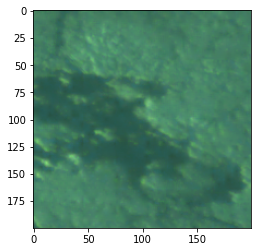

In [34]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
hue_example = tf.image.stateless_random_hue(x_train[image_to_visualize], 0.3, augmentation_seed)
print(hue_example)
plt.imshow(hue_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 71 130 115]
  [ 70 126 114]
  [ 70 125 114]
  ...
  [ 66 122 115]
  [ 66 123 116]
  [ 66 121 117]]

 [[ 75 130 116]
  [ 73 128 115]
  [ 70 127 114]
  ...
  [ 66 122 114]
  [ 66 122 115]
  [ 65 122 116]]

 [[ 80 134 118]
  [ 75 127 116]
  [ 68 126 116]
  ...
  [ 64 122 113]
  [ 64 122 114]
  [ 65 121 115]]

 ...

 [[ 50 101 102]
  [ 56 106 106]
  [ 62 117 111]
  ...
  [ 65 125 117]
  [ 65 123 116]
  [ 65 125 116]]

 [[ 46  95  98]
  [ 52  99 103]
  [ 58 108 108]
  ...
  [ 65 123 116]
  [ 64 120 114]
  [ 63 121 115]]

 [[ 45  92  95]
  [ 49  96 100]
  [ 53  99 105]
  ...
  [ 65 121 115]
  [ 64 120 114]
  [ 63 120 115]]], shape=(200, 200, 3), dtype=int32)


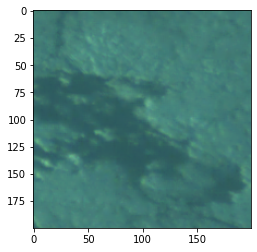

In [35]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
contrast_example = tf.image.stateless_random_contrast(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed)
print(contrast_example)
plt.imshow(contrast_example.numpy().astype('uint8'))

tf.Tensor(
[[[ 72 134 115]
  [ 71 129 113]
  [ 71 128 113]
  ...
  [ 66 123 115]
  [ 65 125 116]
  [ 65 122 117]]

 [[ 78 134 116]
  [ 75 131 115]
  [ 71 130 113]
  ...
  [ 66 124 114]
  [ 65 124 115]
  [ 64 123 116]]

 [[ 84 139 119]
  [ 79 130 116]
  [ 68 129 116]
  ...
  [ 63 123 112]
  [ 63 123 114]
  [ 64 122 115]]

 ...

 [[ 44  94  98]
  [ 53 100 103]
  [ 60 116 109]
  ...
  [ 64 127 117]
  [ 64 125 116]
  [ 64 127 116]]

 [[ 38  86  93]
  [ 46  91  99]
  [ 56 104 106]
  ...
  [ 64 125 116]
  [ 63 121 114]
  [ 61 122 115]]

 [[ 38  81  88]
  [ 42  87  96]
  [ 48  91 102]
  ...
  [ 64 122 115]
  [ 63 121 113]
  [ 61 121 115]]], shape=(200, 200, 3), dtype=int32)


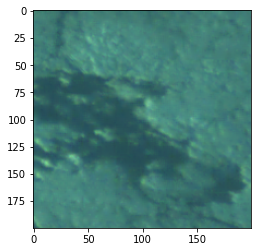

In [36]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
saturation_example = tf.image.stateless_random_saturation(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed)
print(saturation_example)
plt.imshow(saturation_example.numpy().astype('uint8'))

[[[ 78.00540758 132.88506322 121.22283604]
  [ 85.28142039 127.11183214 112.11196453]
  [ 85.73446899 134.18844633 110.21424868]
  ...
  [ 64.14826204 126.86240137 118.69058717]
  [ 75.36652294 120.88732567 114.82378033]
  [ 59.10743729 118.41730444 121.04247875]]

 [[ 86.10421089 126.56383585 124.0123352 ]
  [ 87.93160346 134.33385969 131.13412115]
  [ 66.76031244 119.9633434   99.65674137]
  ...
  [ 57.2426745  119.15068676 117.57866013]
  [ 54.15440433 127.55190373 115.84164456]
  [ 70.45517293 124.80560059 128.00016656]]

 [[ 87.00978635 135.53735615 120.98618359]
  [ 84.38105101 130.39399823 117.32732361]
  [ 64.33927379 123.65449426 105.68966034]
  ...
  [ 65.92754822 121.70871988 118.4135575 ]
  [ 66.71917668 116.93626366 112.42721031]
  [ 59.5810003  130.67671501 116.17185304]]

 ...

 [[ 55.20853035  85.82071923 102.56312122]
  [ 40.62235215  93.30613415  96.05713978]
  [ 56.42607808 110.22114343 112.73604506]
  ...
  [ 71.4264992  112.19355829 106.16514903]
  [ 49.4370646  12

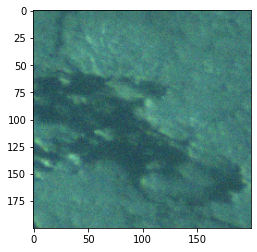

In [37]:
#amount = random.choice([0.01, 0.02, 0.03, 0.04, 0.05])
#random_noise_example = random_noise(x_train[image_to_visualize]/255, mode='s&p', amount=amount, seed=seed)*255
random_noise_example = random_noise(x_train[image_to_visualize]/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255
print(random_noise_example)
plt.imshow(random_noise_example.astype('uint8'))

#### Apply augmentations to all train images n times

In [38]:
%%time

num_augmentations = 20

if num_augmentations == 0:
  pass

else:

  x_train_augmented = np.copy(x_train)

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = tf.image.stateless_random_brightness(x_train/255, 0.2, augmentation_seed)*255

    augmentations = tf.image.stateless_random_flip_left_right(augmentations, augmentation_seed)

    augmentations = tf.image.stateless_random_flip_up_down(augmentations, augmentation_seed)

    k = random.choice([0, 1, 2, 3])
    augmentations = np.array([tf.image.rot90(image, k=k) for image in augmentations])

    augmentations = tf.image.stateless_random_hue(augmentations, 0.3, augmentation_seed)

    augmentations = tf.image.stateless_random_contrast(augmentations, 0.6, 1.4, augmentation_seed)

    augmentations = tf.image.stateless_random_saturation(augmentations, 0.6, 1.4, augmentation_seed)

    #amount = random.choice([0.01, 0.02, 0.03, 0.04, 0.05])
    #augmentations = np.array([random_noise(image.numpy()/255, mode='s&p', amount=amount, seed=seed)*255 for image in augmentations])
    augmentations = np.array([random_noise(image.numpy()/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255 for image in augmentations])

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train] * (num_augmentations + 1))

[50919 15377]
[18854 11114]
[ 8657 62798]
[30893 33932]
[22261  5949]
[ 8032 57878]
[34503 10147]
[30069 63841]
[56831 12862]
[24431 64371]
[51024 50923]
[48374 54585]
[47582 20607]
[35083 57280]
[40000 58694]
[48333 15873]
[58152 38877]
[54978 40134]
[54585 35948]
[40176 44443]
CPU times: user 22.5 s, sys: 1.85 s, total: 24.4 s
Wall time: 29.3 s


In [39]:
x_train.shape

(80, 200, 200, 3)

In [40]:
augmentations.shape

(80, 200, 200, 3)

In [41]:
x_train_augmented.shape

(1680, 200, 200, 3)

In [42]:
y_train.shape

(80,)

In [43]:
y_train_augmented.shape

(1680,)

In [44]:
# TODO
# check pixel range
# check data types
# remove duplicates
# visualize selection of augmented images

### Shuffle and convert images and labels

In [45]:
if num_augmentations == 0:
  x_train, y_train = shuffle(x_train, y_train, random_state=seed)
  x_train = tf.convert_to_tensor(x_train)
  y_train = tf.convert_to_tensor(y_train, dtype=np.int32)

else:
  x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented, random_state=seed)
  x_train = tf.convert_to_tensor(x_train_augmented)
  y_train = tf.convert_to_tensor(y_train_augmented, dtype=np.int32)

#x_val, y_val = shuffle(x_val, y_val, random_state=seed)
#x_val = tf.convert_to_tensor(x_val)
#y_val = tf.convert_to_tensor(y_val, dtype=np.int32)

print(x_train.shape, y_train.shape)#, x_val.shape, y_val.shape)

(1680, 200, 200, 3) (1680,)


# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8, callbacks=[callback], validation_split=0.2, shuffle=False)

Epoch 1/100
168/168 [==============================] - 18s 64ms/step - loss: 4.0200 - sparse_categorical_accuracy: 0.1458 - val_loss: 4.8936 - val_sparse_categorical_accuracy: 0.1875
Epoch 2/100
168/168 [==============================] - 10s 60ms/step - loss: 3.0436 - sparse_categorical_accuracy: 0.1503 - val_loss: 2.6923 - val_sparse_categorical_accuracy: 0.2262
Epoch 3/100
168/168 [==============================] - 10s 60ms/step - loss: 2.7777 - sparse_categorical_accuracy: 0.1763 - val_loss: 2.3953 - val_sparse_categorical_accuracy: 0.1935
Epoch 4/100
168/168 [==============================] - 10s 60ms/step - loss: 2.4418 - sparse_categorical_accuracy: 0.2024 - val_loss: 2.2768 - val_sparse_categorical_accuracy: 0.1994
Epoch 5/100
168/168 [==============================] - 10s 59ms/step - loss: 2.2671 - sparse_categorical_accuracy: 0.2135 - val_loss: 2.1168 - val_sparse_categorical_accuracy: 0.2381
Epoch 6/100
168/168 [==============================] - 10s 59ms/step - loss: 2.1253 -

### Plot loss and accuracy

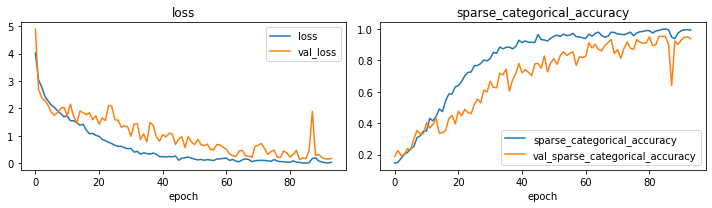

In [49]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

In [50]:
print('min val loss: {}'.format(round(min(history.history['val_loss']), 3)))

min val loss: 0.128


Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [51]:
%%time
predictions = evaluate_model(x_train, y_train)

Score: 0.025850340136054473
CPU times: user 1min 17s, sys: 3.03 s, total: 1min 20s
Wall time: 1min 19s


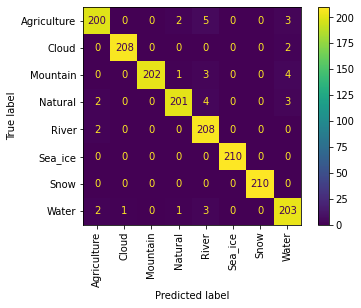

In [52]:
get_confusion_matrix(y_train, predictions)

Class: Agriculture
Predicted: Agriculture


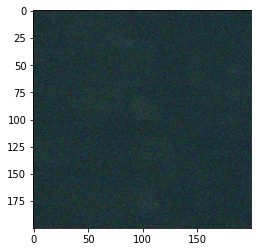

In [53]:
visualize_image(x_train.numpy().astype(int), y_train.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [54]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

Accuracy: 0.977
Precision: 0.977
Recall: 0.977
F1-Score: 0.977
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       210
           1       1.00      0.99      0.99       210
           2       1.00      0.96      0.98       210
           3       0.98      0.96      0.97       210
           4       0.93      0.99      0.96       210
           5       1.00      1.00      1.00       210
           6       1.00      1.00      1.00       210
           7       0.94      0.97      0.96       210

    accuracy                           0.98      1680
   macro avg       0.98      0.98      0.98      1680
weighted avg       0.98      0.98      0.98      1680



### Evaluation on val set

In [55]:
%%time
#predictions = evaluate_model(x_val, y_val)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [56]:
#get_confusion_matrix(y_val, predictions)

In [57]:
#visualize_image(x_val.numpy().astype(int), y_val.numpy(), 10, pred=True, predictions=predictions)

In [58]:
#print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
#print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
#print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

#print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

#print(metrics.classification_report(y_val, predictions))

# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [59]:
#Saving model
model.save_weights('v27.h5')

The trained model can be also loaded for further testing. 

In [60]:
#model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v27.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [61]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train, y_train)

Score: 0.025850340136054473
